In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# Contents
1. 데이터 불러오기
2. 데이터 전처리
3. 시계열 안정성 분석
4. 안정적이지 않은 시계열 직접 안정적으로 만들어보기
5. 시계열 분해
6. 학습 데이터 분리
7. 적정 ARIMA 모수 찾기
8. 함수 만들어서 다른 종목에 적용해보자

# 1. 데이터 불러오기

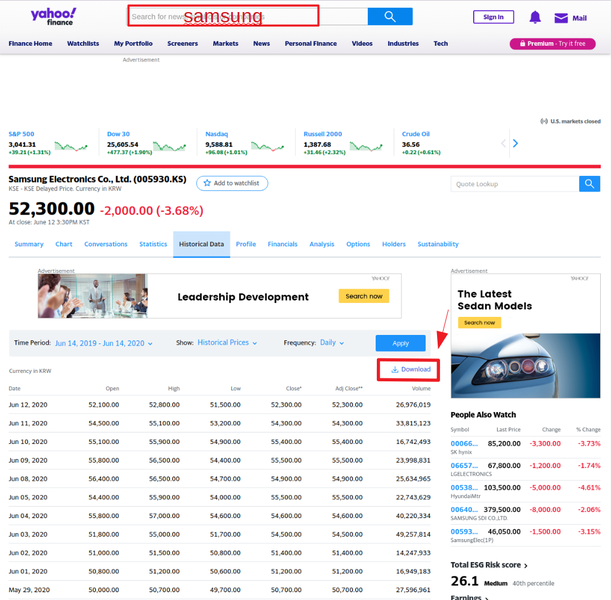

#### Yahoo Finance에서 가져온 삼성전자 주가 데이터 

- 시간 컬럼을 index로 가져오자

In [2]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
245,2021-05-12,80800.0,81200.0,79800.0,80000.0,80000.0,35812268
246,2021-05-13,78900.0,79600.0,78400.0,78500.0,78500.0,31490096
247,2021-05-14,79000.0,80300.0,78900.0,80100.0,80100.0,16450920
248,2021-05-17,80800.0,80900.0,79200.0,79600.0,79600.0,17740855
249,2021-05-18,79600.0,80000.0,79100.0,79600.0,79600.0,17265868


In [4]:
# 종가인 'Close'만 사용
ts1 = df['Close']
ts1.head

<bound method NDFrame.head of 0      48800.0
1      50300.0
2      50000.0
3      49950.0
4      48750.0
        ...   
245    80000.0
246    78500.0
247    80100.0
248    79600.0
249    79600.0
Name: Close, Length: 250, dtype: float64>

In [5]:
ts1

0      48800.0
1      50300.0
2      50000.0
3      49950.0
4      48750.0
        ...   
245    80000.0
246    78500.0
247    80100.0
248    79600.0
249    79600.0
Name: Close, Length: 250, dtype: float64

# 2. 데이터 전처리
### 2.1 결측치 처리

In [6]:
# 결측치 유무 확인
ts1[ts1.isna()] # 결측치 없음

Series([], Name: Close, dtype: float64)

In [7]:
# 먄약 결측치 있다면 
# 1. 결측치 데이터 drop
# 2. 결측치 양옆값으로 보간해 대입
# 2번 방법으로 결측치 보간 처리 메서드 해보자
ts1=ts1.interpolate(method='time')

print(ts1[ts1.isna()])

Series([], Name: Close, dtype: float64)


### 2.2 로그 변환

In [8]:
ts_log = np.log(ts1)

# 3. 시계열 안정성 분석

### 3.1 정성적 그래프 분석

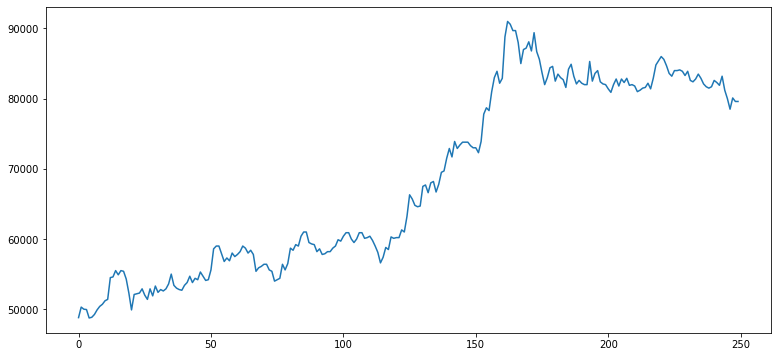

In [9]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts1)

#### 구간 통계치(Rolling Statistics)를 시각화

- 구간의 평균(rolling mean, 이동평균)과 표준편차(rolling std, 이동표준편차)를 원본 시계열과 같이 시각화


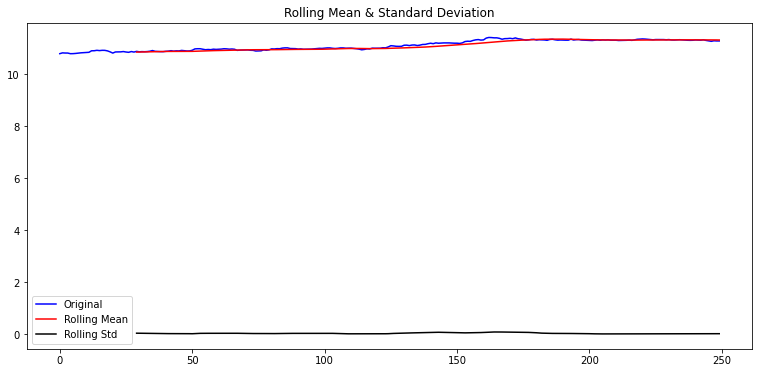

In [10]:
def plot_rolling_statistics(timeseries, window=30):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


plot_rolling_statistics(ts_log, window=30)

### 3.2 정량적 Augmented Dickey-Fuller Test

In [11]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# ts1(주식 종가) 시계열 안정성 테스트
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


-> p-value 0.59로 0에 가깝지 않기 때문에 귀무가설 기각할 수 없게 되어 이 시계열이 안정적이라고 말할 수 없다.

# 4. 안정적이지 않은 시계열 직접 안정적으로 만들어보기

### 4-1. Moving average 제거 - 추세(Trend) 상쇄하기

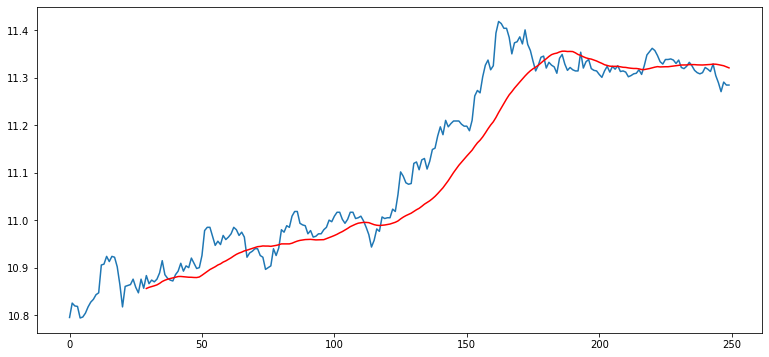

In [12]:
moving_avg = ts_log.rolling(window=30).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [13]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(60)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14         NaN
15         NaN
16         NaN
17         NaN
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
24         NaN
25         NaN
26         NaN
27         NaN
28         NaN
29    0.027160
30    0.007758
31    0.013746
32    0.008261
33    0.012035
34    0.022019
35    0.043851
36    0.011632
37    0.002104
38   -0.003227
39   -0.006413
40    0.005380
41    0.011322
42    0.027790
43    0.011692
44    0.023450
45    0.020194
46    0.040406
47    0.029921
48    0.019014
49    0.019672
50    0.041569
51    0.090201
52    0.092922
53    0.088904
54    0.067073
55    0.044949
56    0.050092
57    0.040657
58    0.056100
59    0.044914
Name: Close, dtype: float64

-> window=12 일때, 앞에 11개 데이터에 이동평균 계산이 되지 않아 NaN이 발생

In [14]:
# 위에서 발생한 결측치 NaN 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(50)

29    0.027160
30    0.007758
31    0.013746
32    0.008261
33    0.012035
34    0.022019
35    0.043851
36    0.011632
37    0.002104
38   -0.003227
39   -0.006413
40    0.005380
41    0.011322
42    0.027790
43    0.011692
44    0.023450
45    0.020194
46    0.040406
47    0.029921
48    0.019014
49    0.019672
50    0.041569
51    0.090201
52    0.092922
53    0.088904
54    0.067073
55    0.044949
56    0.050092
57    0.040657
58    0.056100
59    0.044914
60    0.046848
61    0.050499
62    0.060324
63    0.051758
64    0.037131
65    0.042005
66    0.029039
67   -0.014847
68   -0.007764
69   -0.006276
70   -0.002765
71   -0.004338
72   -0.019168
73   -0.023749
74   -0.049098
75   -0.045401
76   -0.041171
77   -0.006086
78   -0.021284
Name: Close, dtype: float64

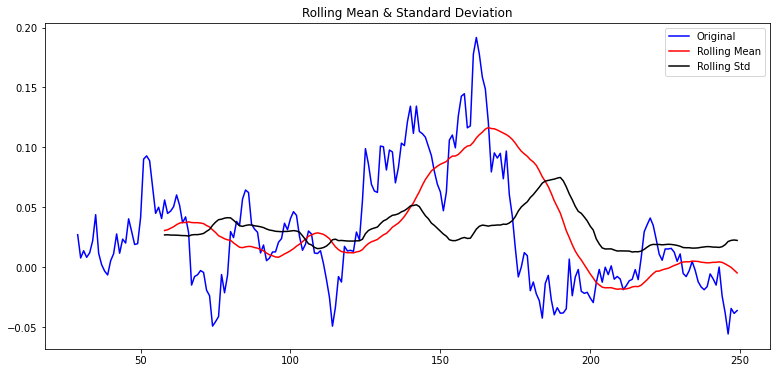

In [15]:
# 정성적 분석
plot_rolling_statistics(ts_log_moving_avg)

In [16]:
# 정량적 분석
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -2.241525
p-value                          0.191521
#Lags Used                       0.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


-> p값 0에 가깝기 때문에 귀무가설 기각, 시계열 안정적으로 만듦!

### 4-2. 차분(Differencing) - 계절성(Seasonality) 상쇄하기

추이(trend) 에는 안잡히지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해되는 불안정성 요소이다.

이것은 Moving Average 제거로는 상쇄되지 않는 효과.

이런 계절적, 주기적 패턴을 **계절성(Seasonality)**라고 한다.

이 패턴을 상쇄하기 위한 방법으로는 **차분(Differencing)**이 있다.

차분이란 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법이다.

(**현재 스텝 값 - 직전 스텝 값**)이 되어 정확히 **이번 스텝에서 발생한 변화량**을 의미

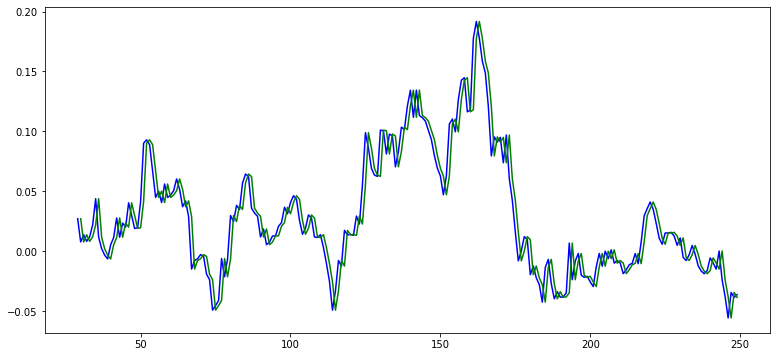

In [17]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

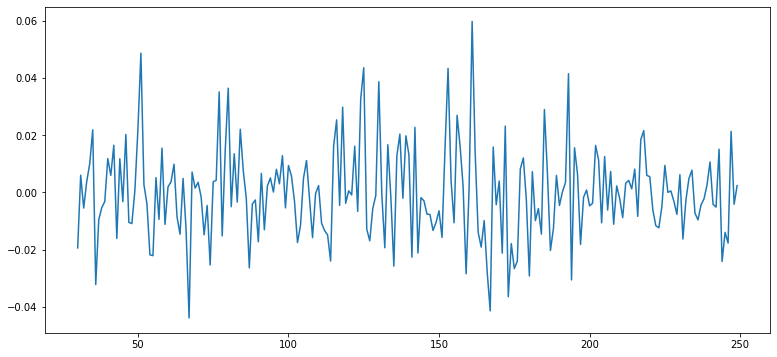

In [18]:
# 차분한 값 그래프로 시각화
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

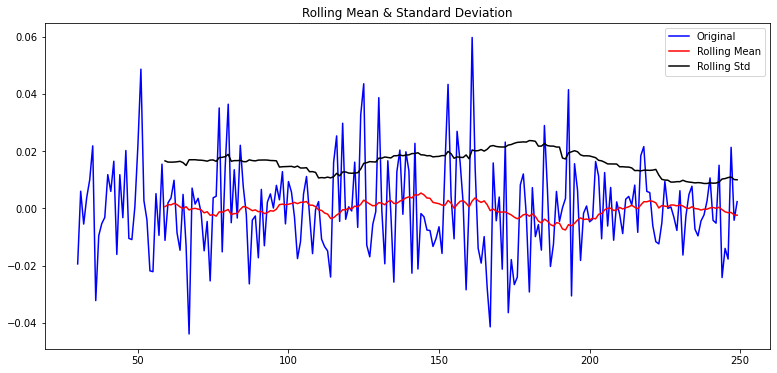

In [19]:
# 안정성 여부 파악 - 정성적
plot_rolling_statistics(ts_log_moving_avg_diff)

In [20]:
# 안정성 여부 파악 - 정량적
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.434365e+01
p-value                        1.049787e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64


-> 이동평균 빼서 추세 제거하고 난 시계열에 1차 차분 적용해 계절성 상쇄한 결과, p값이 매우 작아졌다!

# 5.  시계열 분해(Time series decomposition)

statsmodels 라이브러리 안에는 ``seasonal_decompose`` 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있다.

In [21]:
ts_log

0      10.795486
1      10.825760
2      10.819778
3      10.818778
4      10.794460
         ...    
245    11.289782
246    11.270854
247    11.291031
248    11.284769
249    11.284769
Name: Close, Length: 250, dtype: float64

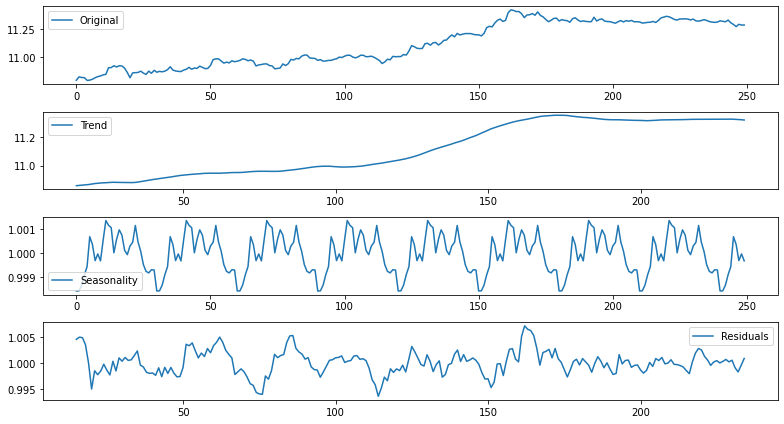

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative',period=30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

$ Residual = Original - Trend - Seasonality $

밑에서 Residual의 안정성 테스트 해보자

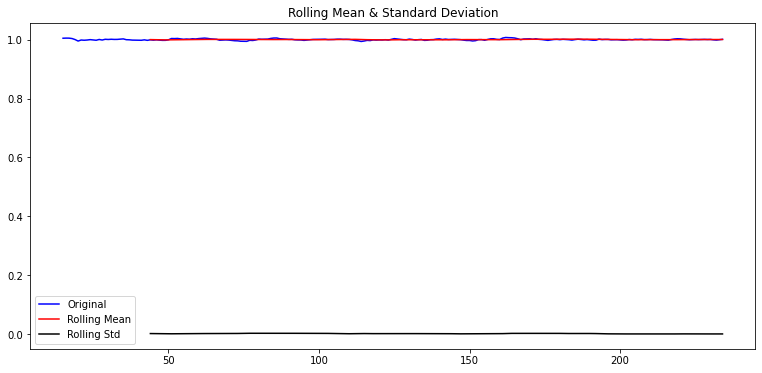

In [23]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [24]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


-> Decomposing으로 Residual은 압도적으로 낮은 P값 가짐

# 6. 학습 데이터 분리

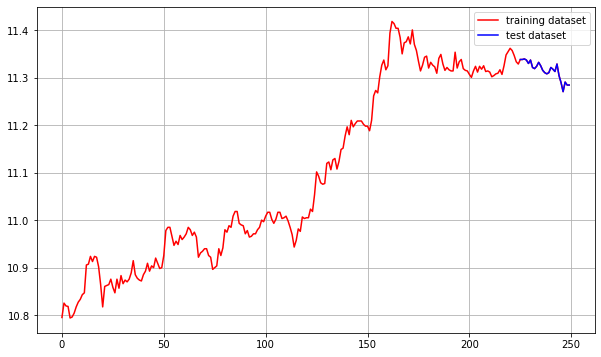

In [25]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [26]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

0    10.795486
1    10.825760
Name: Close, dtype: float64
(225,)
(25,)


# 7. 적정 ARIMA 모수 찾기

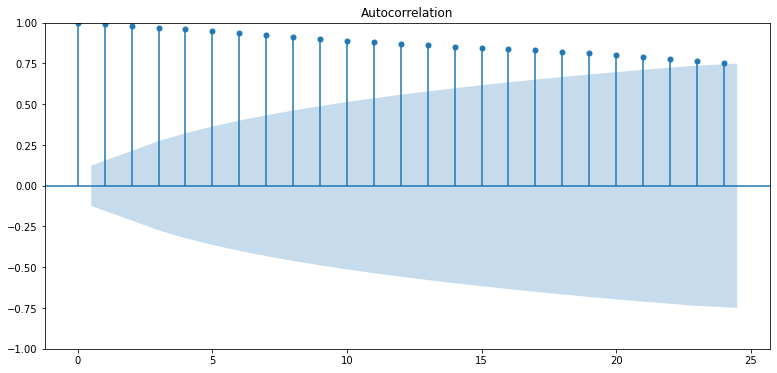

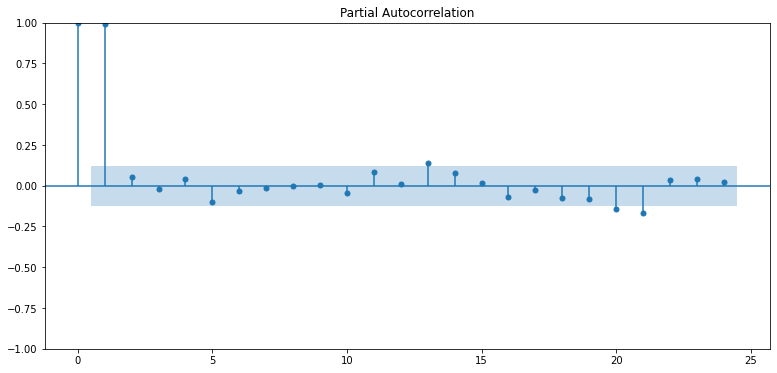

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있음
- ACF에선 0으로 점차 소멸하는 구간이 없어 q 결정할 수 없음.
- PACF에선 p=1 or p=21 

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


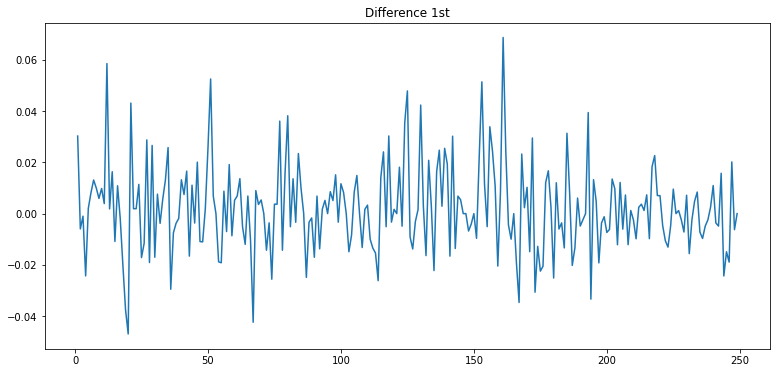

In [28]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분으로도 p-value 충분히 작기 때문에 d = 1로 하자

In [29]:
# 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_testb(diff_2)

# 8. ARIMA 모델 훈련과 추론

In [30]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 1, 0)) # order = (p, d, q) 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Tue, 15 Feb 2022   AIC                          -1162.976
Time:                        09:13:49   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

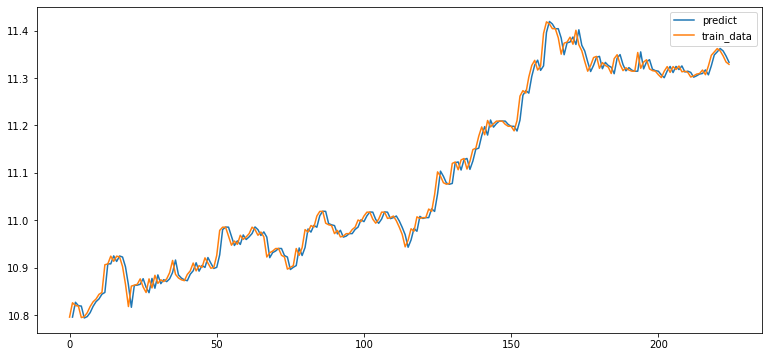

In [31]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

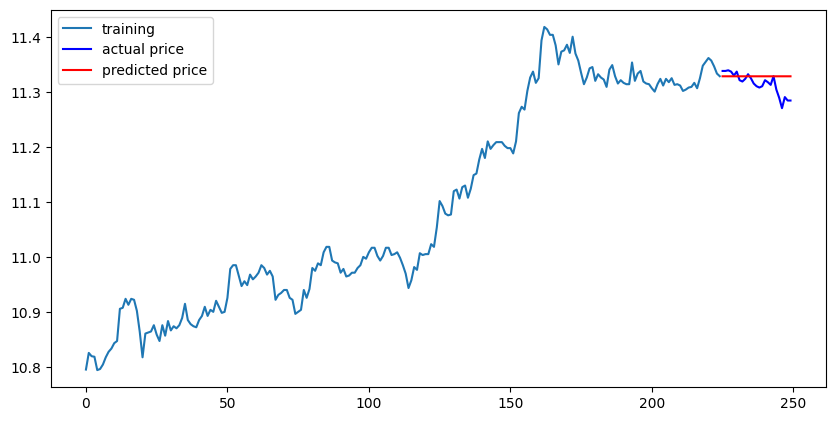

In [32]:
# 테스트 구간의 데이터 예측
model = ARIMA(train_data, order=(1, 1, 0))  # p값을 1 or 21으로 테스트
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산 가능

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


# 8. 함수로 만들어서 다른 종목에 적용해보자

In [34]:
file = '005930.KS.csv'

In [35]:
def data_load_preprocess(file):
    # 1. 데이터 불러오기
    dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/' + file
    df = pd.read_csv(dataset_filepath) 
    
    # 종가 컬럼만 사용
    ts = df['Close']
    
    # 2. 데이터 전처리
    # 결측치 유무 확인
    ts[ts.isna()]
    # 결측치 있다면 양옆값으로 보간해 대입
    ts = ts.interpolate(method='time')
    
    # 로그 변환
    ts_log = np.log(ts)
    
    return ts_log

In [36]:
from statsmodels.tsa.stattools import adfuller # Augmented Dicky-Fuller Test 하기 위해 필요
from statsmodels.tsa.seasonal import seasonal_decompose # 시계열 분해에 필요한 모듈

# 정성적 그래프 분석 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)



#정량적 Augmented Dicky-Fuller Test 함수
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)



### 위에 그래프 함수 사용 + 시계열 분해하는 함수 만들기

In [37]:
def graph_analysis_and_decompose(ts_log):
    
    # 정성적 그래프 분석
    print(plot_rolling_statistics(ts_log, window=12))

    #정량적 Augmented Dicky-Fuller Test
    print(augmented_dickey_fuller_test(ts_log))
     
    # 시계열 분해
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
    seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
    residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

    plt.rcParams["figure.figsize"] = (11,6)
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout() 
    
    # Residual 안정성 확인 
    plt.rcParams["figure.figsize"] = (13,6)
    plot_rolling_statistics(residual)


In [38]:
# 학습, 테스트 데이터셋 분리 함수
def ARIMA_train_test_split(ts_log):
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    return train_data, test_data

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# p,q 구하는 함수
def find_ARIMA_pq(ts_log):
    plot_acf(ts_log)
    plot_pacf(ts_log)
    plt.show()

In [40]:
# 차분 안정성 확인 함수 -> d 구하기 
def find_ARIMA_d(ts_log):
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')

    print(augmented_dickey_fuller_test(diff_1))

In [41]:
import warnings
warnings.filterwarnings('ignore') #경고 무시
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# ARIMA 모델 훈련/테스트 함수
def ARIMA_model_train_test(train_data,p,d,q,test_data):
    # Build Model
    model = ARIMA(train_data, order=(p, d, q)) 
    fitted_m = model.fit() 
    print(fitted_m.summary())
    
    # (1) 모델훈련 결과 확인
    fitted_m = fitted_m.predict()
    fitted_m = fitted_m.drop(fitted_m.index[0])
    plt.plot(fitted_m, label='predict')
    plt.plot(train_data, label='train_data')
    plt.legend()
    
    # (2) 테스트 데이터 구간 예측
    model = ARIMA(train_data, order=(21, 1, 0))  # p값을 21으로 테스트
    fitted_m = model.fit() 
    fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # (3) 예측결과 pandas series로 생성
    fc_series = pd.Series(fc, index=test_data.index) 

    # (4) Plot으로 시각화
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()
    
    # (5) 오차 계산
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))

## 8.1 AAPL 주가 예측

애플 데이터 -> https://kr.investing.com/equities/apple-computer-inc-historical-data

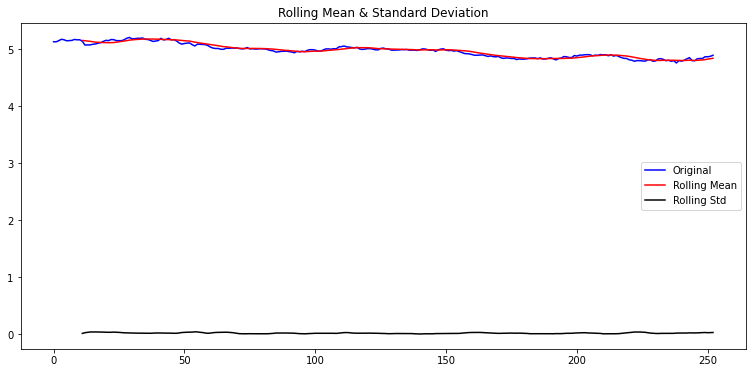

None
Results of Dickey-Fuller Test:
Test Statistic                  -1.373555
p-value                          0.594887
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64
None


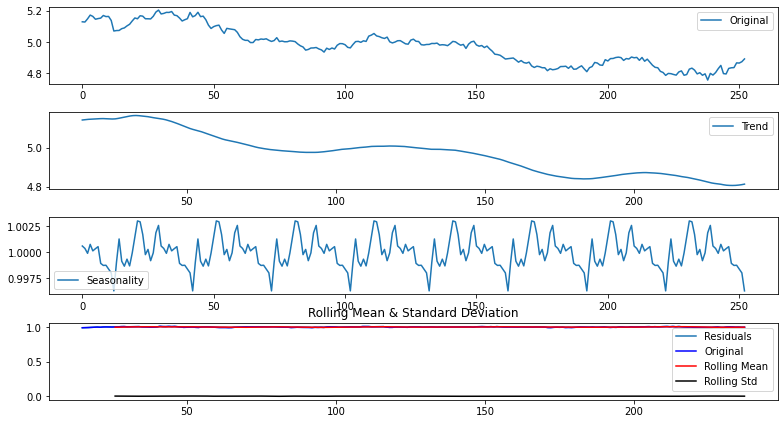

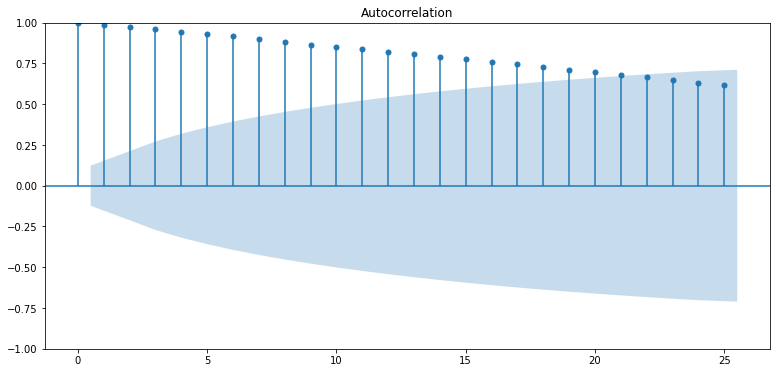

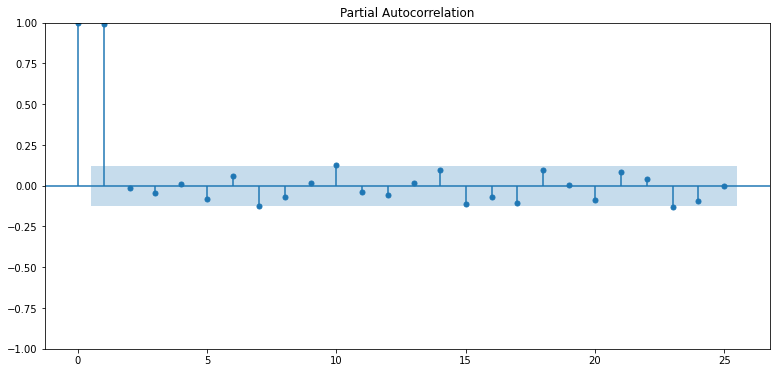

Results of Dickey-Fuller Test:
Test Statistic                -1.598110e+01
p-value                        6.834151e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
None


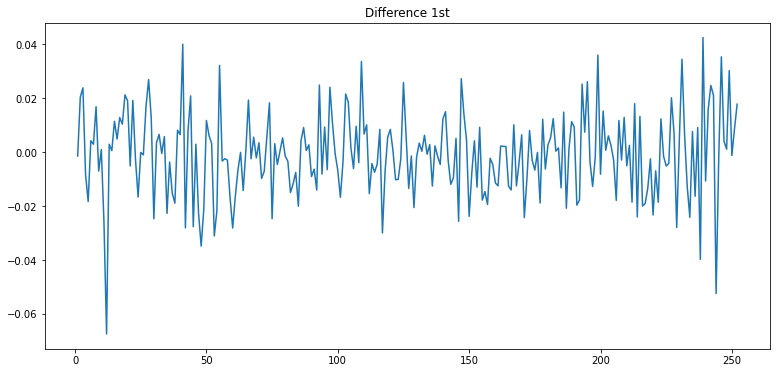

In [42]:
file = 'AAPL_stock_price.csv'

# 데이터 로드 및 전처리
ts_log = data_load_preprocess(file)

# 정성적 + 정량적 분석 & 시계열 분해
graph_analysis_and_decompose(ts_log)

# train, test 데이터셋 분리
train_data, test_data = ARIMA_train_test_split(ts_log)

# p,q 구하기
find_ARIMA_pq(ts_log)

# d 구하기
find_ARIMA_d(ts_log)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 635.102
Date:                Tue, 15 Feb 2022   AIC                          -1266.205
Time:                        09:13:51   BIC                          -1259.364
Sample:                             0   HQIC                         -1263.444
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0407      0.062      0.651      0.515      -0.082       0.163
sigma2         0.0002   1.61e-05     13.195      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.03   Jarque-

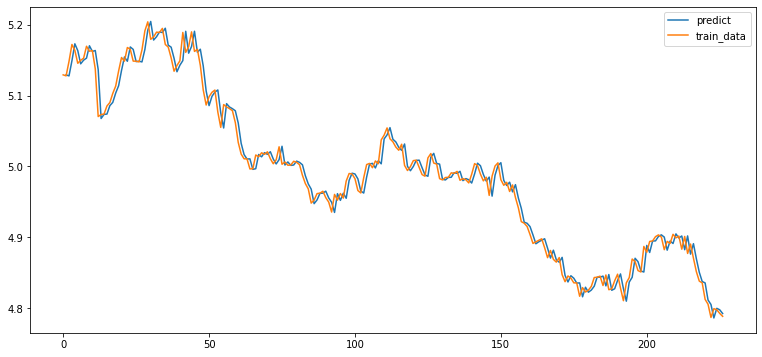

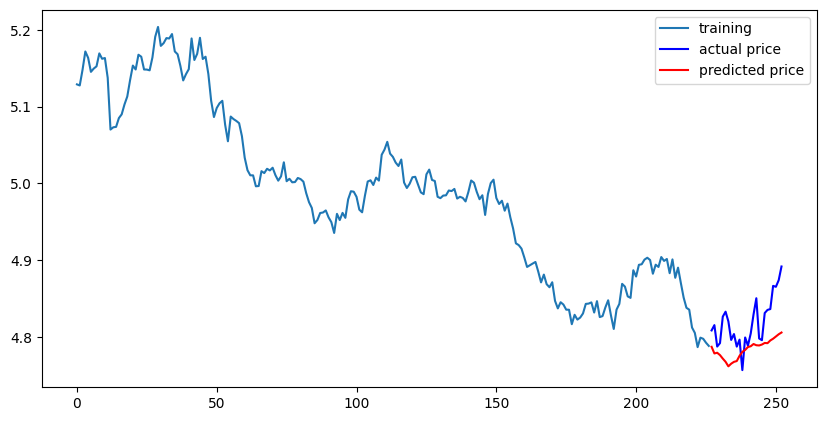

MSE:  28.75610267089955
MAE:  4.512198327064359
RMSE:  5.362471694181663
MAPE: 3.58%


In [43]:
# ACF, PCF, diff 따라서 p,q,d 하이퍼 파라미터 설정
p = 1
q = 0
d = 1

# 훈련 & 테스트 & 오차결과
ARIMA_model_train_test(train_data,p,d,q,test_data)

## 8.2 U 주가 예측
유니티 소프트웨어 데이터 -> https://kr.investing.com/equities/unity-software-inc-historical-data

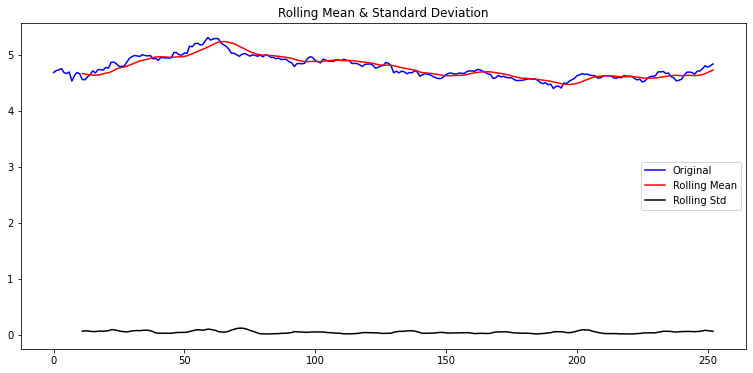

None
Results of Dickey-Fuller Test:
Test Statistic                  -1.536509
p-value                          0.515380
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64
None


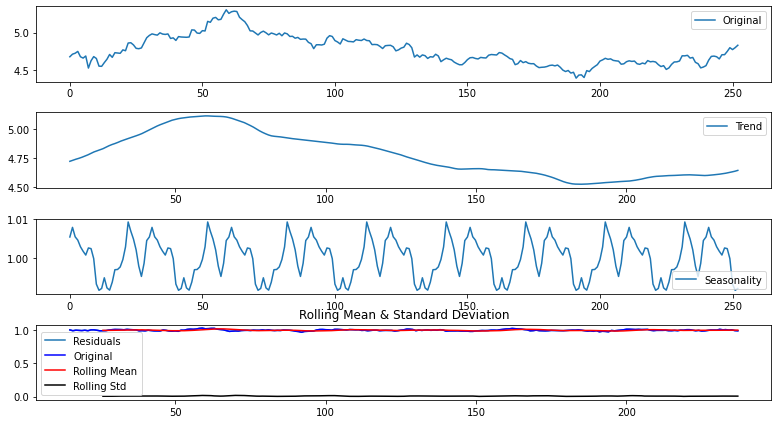

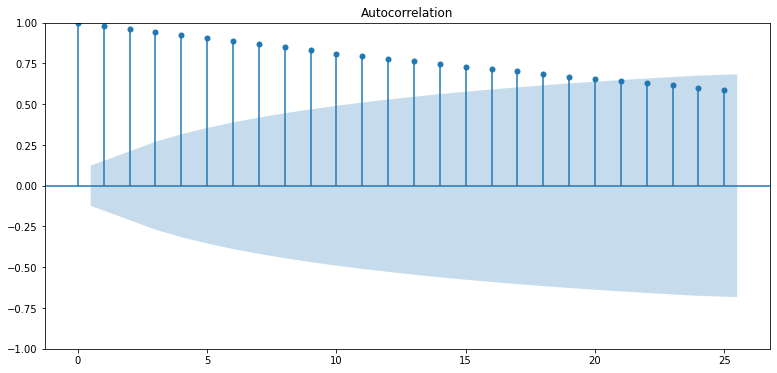

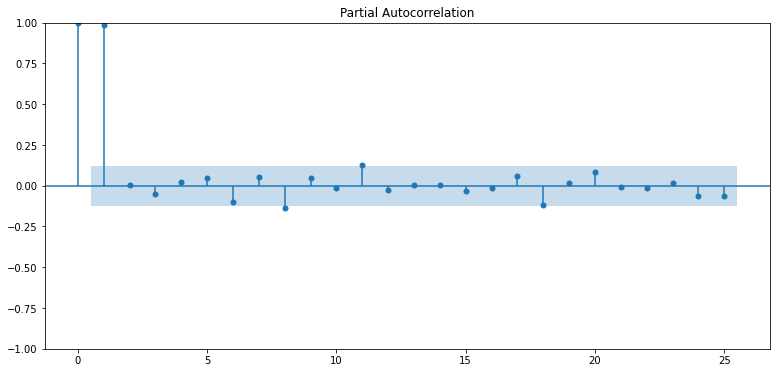

Results of Dickey-Fuller Test:
Test Statistic                -1.066028e+01
p-value                        4.425450e-19
#Lags Used                     1.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
None


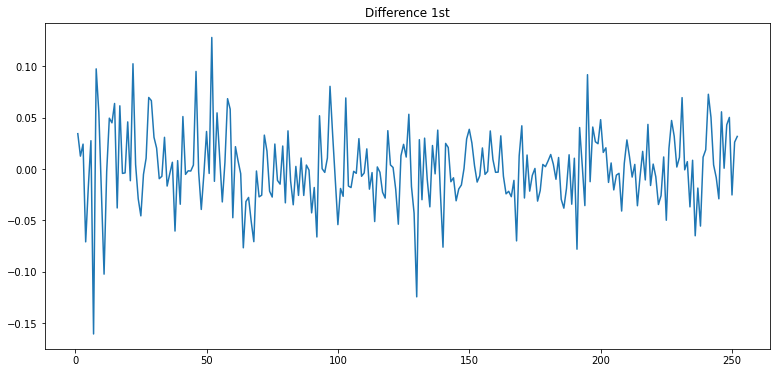

In [44]:
file = 'U_stock_price.csv'

# 데이터 로드 및 전처리
ts_log = data_load_preprocess(file)

# 정성적 + 정량적 분석 & 시계열 분해
graph_analysis_and_decompose(ts_log)

# train, test 데이터셋 분리
train_data, test_data = ARIMA_train_test_split(ts_log)

# p,q 구하기
find_ARIMA_pq(ts_log)

# d 구하기
find_ARIMA_d(ts_log)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 425.073
Date:                Tue, 15 Feb 2022   AIC                           -846.146
Time:                        09:13:57   BIC                           -839.305
Sample:                             0   HQIC                          -843.385
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0272      0.060     -0.456      0.649      -0.144       0.090
sigma2         0.0014   8.81e-05     15.438      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   0.00   Jarque-

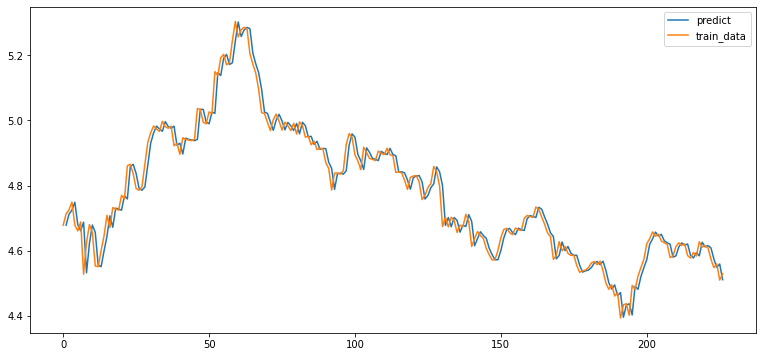

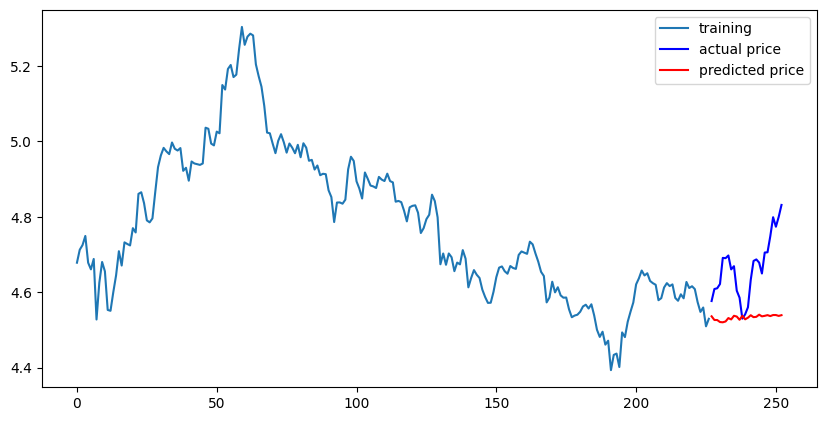

MSE:  255.33094449140046
MAE:  13.7145088350419
RMSE:  15.979078336731455
MAPE: 12.33%


In [45]:
# ACF, PCF, diff 따라서 p,q,d 하이퍼 파라미터 설정
p = 1
q = 0
d = 1

# 훈련 & 테스트 & 오차결과
ARIMA_model_train_test(train_data,p,d,q,test_data)

## 8.3 DIS 주가 예측
월트 디즈니 데이터 -> https://kr.investing.com/equities/disney-historical-data

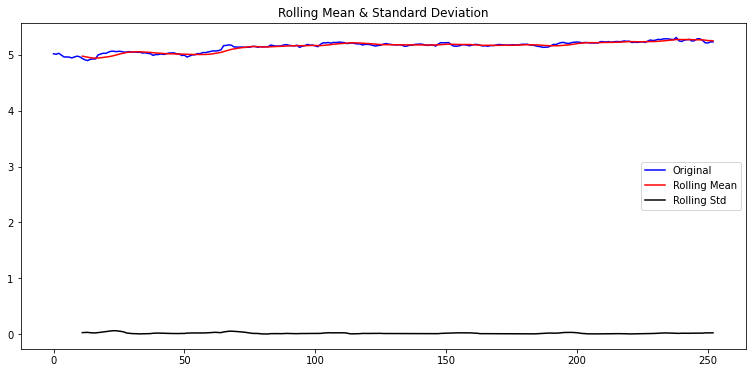

None
Results of Dickey-Fuller Test:
Test Statistic                  -1.622583
p-value                          0.471375
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64
None


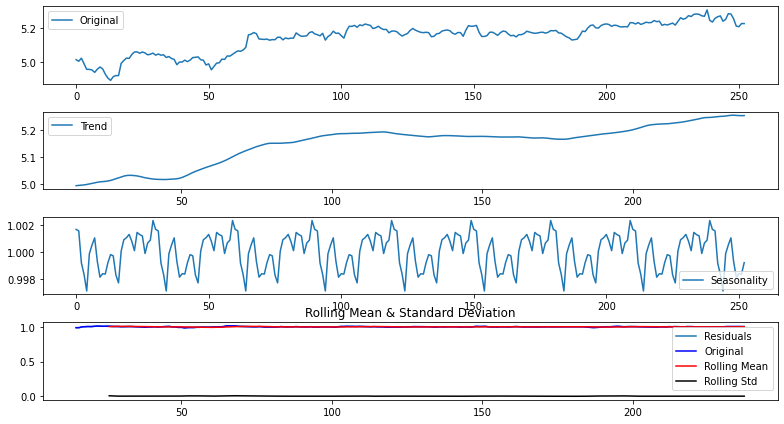

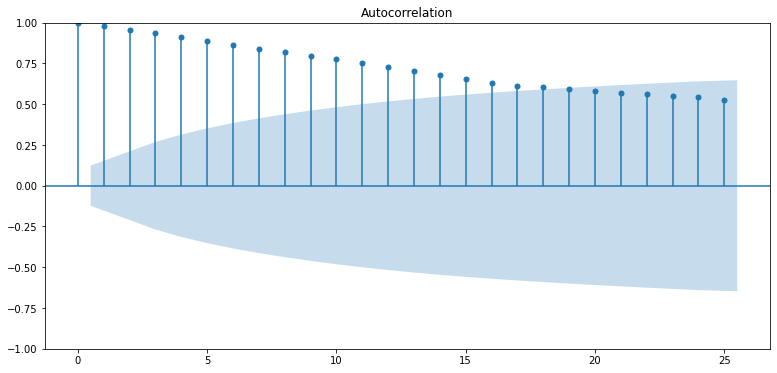

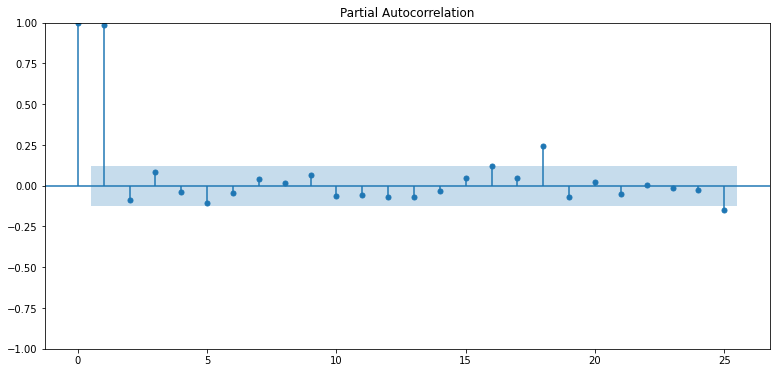

Results of Dickey-Fuller Test:
Test Statistic                -1.489522e+01
p-value                        1.535954e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
None


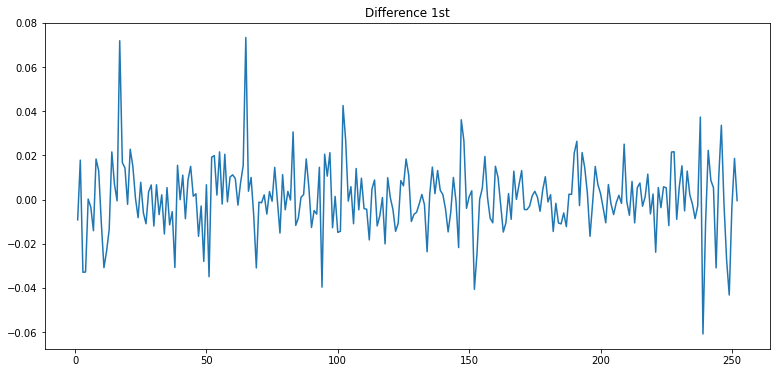

In [46]:
file = 'DIS_stock_price.csv'

# 데이터 로드 및 전처리
ts_log = data_load_preprocess(file)

# 정성적 + 정량적 분석 & 시계열 분해
graph_analysis_and_decompose(ts_log)

# train, test 데이터셋 분리
train_data, test_data = ARIMA_train_test_split(ts_log)

# p,q 구하기
find_ARIMA_pq(ts_log)

# d 구하기
find_ARIMA_d(ts_log)

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 631.019
Date:                Tue, 15 Feb 2022   AIC                          -1258.038
Time:                        09:14:05   BIC                          -1251.197
Sample:                             0   HQIC                         -1255.277
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0898      0.065      1.389      0.165      -0.037       0.216
sigma2         0.0002   1.17e-05     18.855      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

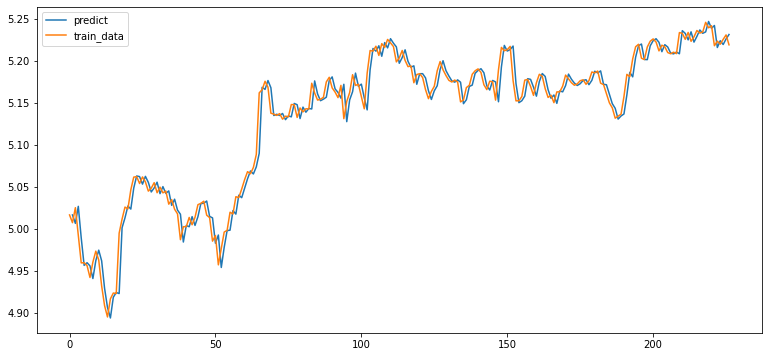

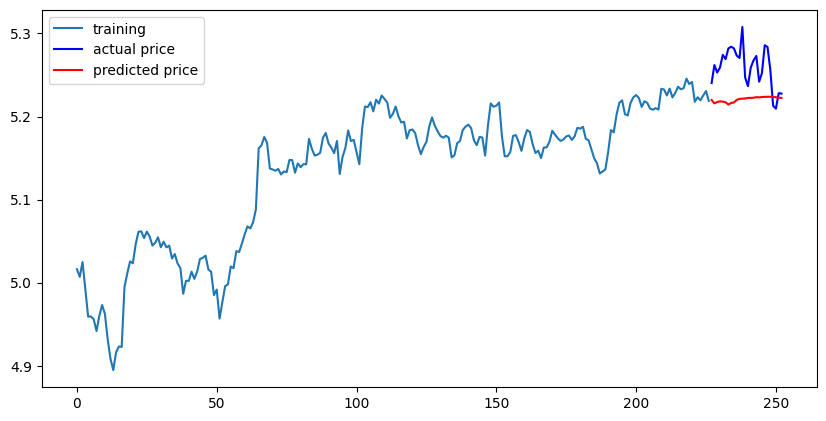

MSE:  75.38536842705244
MAE:  7.6442138299322915
RMSE:  8.682474787009314
MAPE: 3.93%


In [47]:
# ACF, PCF, diff 따라서 p,q,d 하이퍼 파라미터 설정
p = 1
q = 0
d = 1

# 훈련 & 테스트 & 오차결과
ARIMA_model_train_test(train_data,p,d,q,test_data)

# 회고
---
- 내가 현재 관심을 가지고 있는 미국 주식의 주가를 예측해보고 싶어서 삼성전자 이외에
- 애플, 유니티 소프트웨어, 월트 디즈니의 주가를 예측해보는 실습을 진행하였다.
- 유니티 소프트웨어 주가의 경우 이동평균으로 추세 제거 + 차분으로 계절성 제거해도 안정화가 안되어 **MAPE**는 **12.33%** 으로 다른 주식의 주가에 비해 높은 편이었다.
- 하지만 애플, 월트 디즈니의 **MAPE**는 **3%** 대로 비교적 오차률이 작은 편이었다.
- MAPE가 비록 작아보여도 실제 가격과 예측 가격을 그래프로 비교해보면 예측을 제대로 못한것을 확인할 수 있다.
- 다음에는 머신러닝 모델인 ARIMA가 아닌 LSTM을 사용하여 학습해보고 ARIMA 모델 보다 더 잘 예측하는지 확인해보아야겠다.